In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import os, cv2
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.metrics import AUC
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import model_from_json, load_model
from stn import spatial_transformer_network as transformer

In [2]:
dir_list = os.listdir('CK+48')
print(dir_list)

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [3]:
img_list = []
dim = 48
for folder in dir_list:
    img_path_list = os.listdir('CK+48' + '/' + folder)
    for img_path in img_path_list:
        img = cv2.imread('CK+48' + '/' + folder + '/' + img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img = cv2.resize(gray_img, (dim, dim))
        img_resize = gray_img.flatten()
        img_resize = " ".join(str(x) for x in img_resize)
#         dim = int(math.sqrt(len(img_resize.split(' '))))
        img_list.append(tuple([img_resize, folder]))

In [4]:
df = pd.DataFrame(img_list, columns=['pixels', 'emotion'])
df.head()

,pixels,emotion
0,243 239 47 0 0 182 175 0 0 0 37 0 0 0 0 0 11 1...,anger
1,242 252 244 1 0 163 171 0 0 0 31 18 6 0 0 0 12...,anger
2,229 0 0 0 0 188 193 0 0 0 65 38 254 7 0 0 11 0...,anger
3,245 2 254 2 0 206 0 0 0 0 86 76 47 2 0 0 1 255...,anger
4,239 3 20 0 0 213 2 0 0 0 94 65 220 0 0 0 9 0 1...,anger


In [5]:
df.emotion.unique()

array(['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral',
       'sadness', 'surprise'], dtype=object)

In [6]:
emotion_count = df.emotion.value_counts()
print(emotion_count)

neutral      593
surprise      83
happiness     69
disgust       59
anger         45
sadness       28
fear          25
contempt      18
Name: emotion, dtype: int64


<AxesSubplot:ylabel='emotion'>

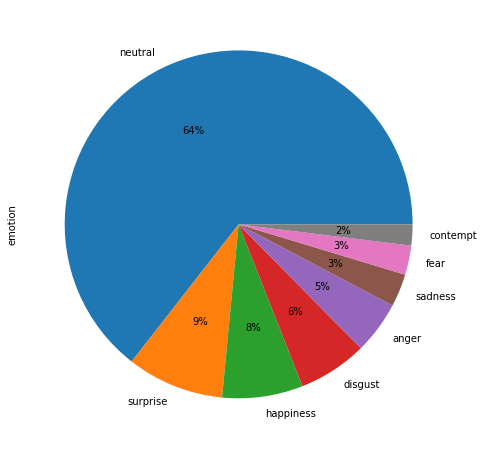

In [7]:
emotion_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

In [8]:
def img_aug(px):
    image = np.array(px.split(' ')).reshape(dim, dim).astype('float32')
    image = tf.image.random_flip_left_right(image.reshape(dim, dim, 1))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.clip_by_value(image, 0, 255)
    augmented_img = image.numpy().reshape(dim, dim)
    img_concat = ' '.join(augmented_img.reshape(dim*dim).astype('int').astype(str))
    return img_concat

valcounts = df.emotion.value_counts()
valcounts_diff = valcounts[valcounts.idxmax()] - valcounts
for emotion_idx, aug_count in valcounts_diff.iteritems():
    sampled = df.query("emotion==@emotion_idx").sample(aug_count, replace=True)
    sampled['pixels'] = sampled.pixels.apply(img_aug)
    df = pd.concat([df, sampled])

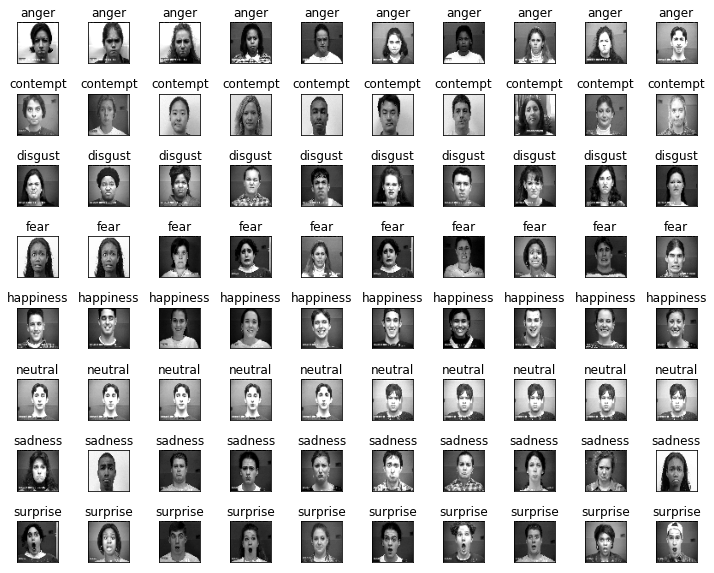

In [9]:
plt.figure(figsize=(10, 10))
count = 0
for label in sorted(df.emotion.unique()):
    for i in range(10):
        px = df[df.emotion==label].pixels.iloc[count]
        px = np.array(px.split(' ')).reshape(dim, dim).astype('float32')
        count += 1
        ax = plt.subplot(10, 10, count)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label)
        plt.tight_layout()

In [10]:
emotion_count = df.emotion.value_counts()
print(emotion_count)

anger        593
contempt     593
disgust      593
fear         593
happiness    593
neutral      593
sadness      593
surprise     593
Name: emotion, dtype: int64


<AxesSubplot:ylabel='emotion'>

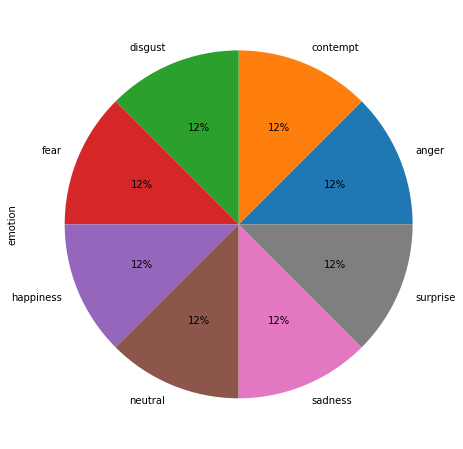

In [11]:
emotion_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

In [12]:
img_df = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(dim, dim, 1).astype('float32'))
img_df = np.stack(img_df, axis=0)

In [13]:
img_df.shape

(4744, 48, 48, 1)

In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(4744, 8)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(img_df, img_labels, shuffle=True, stratify=img_labels, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3795, 48, 48, 1), (949, 48, 48, 1), (3795, 8), (949, 8))

In [16]:
X_train = X_train / 255.
X_test = X_test / 255.

# X_train = X_train.reshape(len(X_train), 48 * 48 * 1)
# s = SMOTE(random_state=42)
# X_smote, y_smote = s.fit_resample(X_train, y_train)
# X_smote = X_smote.reshape(-1, 48, 48, 1)
# X_smote.shape

# class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
# class_weights = dict(enumerate(class_weights))

In [17]:
class STN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(STN, self).__init__(**kwargs)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(32, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(64, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(12, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        out = transformer(inputs, theta)
        return out

In [18]:
def get_stn_model(input_shape):
    
    image = tf.keras.layers.Input(shape=input_shape)
    x = STN()(image)
   
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=input_shape,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)


    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Flatten()(x)
        
    x = tf.keras.layers.Dense(
        256,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        512,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        8,
        activation='softmax',
    )(x)
    
    return tf.keras.models.Model(inputs=image, outputs=x)

In [19]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.0001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint(filepath='saved_models/best_weight_CK+.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)

In [20]:
# X = np.concatenate((X_train, X_test), axis=0)
# y = np.concatenate((y_train, y_test), axis=0)
# acc_per_fold = []
# loss_per_fold = []

# kfold = KFold(n_splits=5)
# fold_count = 1
# for train, test in kfold.split(X, y):
stn_model = get_stn_model((X_train.shape[1], X_train.shape[2], X_train.shape[3]))
batch_size = 32
stn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy', AUC(multi_label=True, num_labels=8)])
# print(f'\nFold {fold_count}/5')
stn_result = stn_model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, steps_per_epoch=len(X_train)/batch_size, 
              epochs=60, callbacks=[checkpoint, reduce_lr])
    
# scores = stn_model.evaluate(X[test], y[test])
# print(f'Fold {fold_count}/5 - {stn_model.metrics_names[0]}: {scores[0]} - {stn_model.metrics_names[1]}: {round(scores[1]*100, 2)}%\n')
# loss_per_fold.append(scores[0])
# acc_per_fold.append(round(scores[1]*100, 2))

# fold_count = fold_count + 1
    
# print(f'val_loss_avg: {np.mean(loss_per_fold)}')
# print(f'val_acc_avg: {round(np.mean(acc_per_fold), 2)}%')


Building Localization Network with input shape: (None, 48, 48, 1)
Epoch 1/60
119/118 [==============================] - ETA: 0s - loss: 15.1730 - accuracy: 0.2572 - auc: 0.6431
Epoch 1: val_accuracy improved from -inf to 0.21842, saving model to saved_models\best_weight_CK+.h5
118/118 [==============================] - 9s 38ms/step - loss: 15.1730 - accuracy: 0.2572 - auc: 0.6431 - val_loss: 11.9732 - val_accuracy: 0.2184 - val_auc: 0.6334 - lr: 0.0010
Epoch 2/60
119/118 [==============================] - ETA: 0s - loss: 9.8551 - accuracy: 0.2803 - auc: 0.6778
Epoch 2: val_accuracy improved from 0.21842 to 0.23158, saving model to saved_models\best_weight_CK+.h5
118/118 [==============================] - 3s 25ms/step - loss: 9.8551 - accuracy: 0.2803 - auc: 0.6778 - val_loss: 8.0983 - val_accuracy: 0.2316 - val_auc: 0.6838 - lr: 0.0010
Epoch 3/60
118/118 [============================>.] - ETA: 0s - loss: 6.8793 - accuracy: 0.3294 - auc: 0.7139
Epoch 3: val_accuracy did not improve from

Epoch 23/60
118/118 [============================>.] - ETA: 0s - loss: 0.8187 - accuracy: 0.9573 - auc: 0.9963
Epoch 23: val_accuracy did not improve from 0.98421
118/118 [==============================] - 3s 29ms/step - loss: 0.8187 - accuracy: 0.9568 - auc: 0.9963 - val_loss: 0.8420 - val_accuracy: 0.9579 - val_auc: 0.9949 - lr: 0.0010
Epoch 24/60
117/118 [============================>.] - ETA: 0s - loss: 0.7377 - accuracy: 0.9647 - auc: 0.9979
Epoch 24: val_accuracy did not improve from 0.98421
118/118 [==============================] - 3s 26ms/step - loss: 0.7364 - accuracy: 0.9645 - auc: 0.9979 - val_loss: 0.9097 - val_accuracy: 0.9289 - val_auc: 0.9865 - lr: 0.0010
Epoch 25/60
117/118 [============================>.] - ETA: 0s - loss: 0.7070 - accuracy: 0.9665 - auc: 0.9965
Epoch 25: val_accuracy did not improve from 0.98421
118/118 [==============================] - 3s 26ms/step - loss: 0.7087 - accuracy: 0.9655 - auc: 0.9966 - val_loss: 0.7397 - val_accuracy: 0.9500 - val_auc: 

118/118 [==============================] - 3s 25ms/step - loss: 0.3560 - accuracy: 0.9963 - auc: 0.9997 - val_loss: 0.3274 - val_accuracy: 0.9974 - val_auc: 0.9985 - lr: 1.0000e-04
Epoch 47/60
117/118 [============================>.] - ETA: 0s - loss: 0.2947 - accuracy: 0.9965 - auc: 1.0000
Epoch 47: val_accuracy did not improve from 0.99737
118/118 [==============================] - 3s 24ms/step - loss: 0.2941 - accuracy: 0.9966 - auc: 1.0000 - val_loss: 0.2807 - val_accuracy: 0.9974 - val_auc: 0.9985 - lr: 1.0000e-04
Epoch 48/60
118/118 [============================>.] - ETA: 0s - loss: 0.2513 - accuracy: 0.9955 - auc: 0.9998
Epoch 48: val_accuracy did not improve from 0.99737
118/118 [==============================] - 3s 24ms/step - loss: 0.2510 - accuracy: 0.9955 - auc: 0.9998 - val_loss: 0.2398 - val_accuracy: 0.9974 - val_auc: 0.9985 - lr: 1.0000e-04
Epoch 49/60
119/118 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9976 - auc: 0.9998
Epoch 49: val_accura

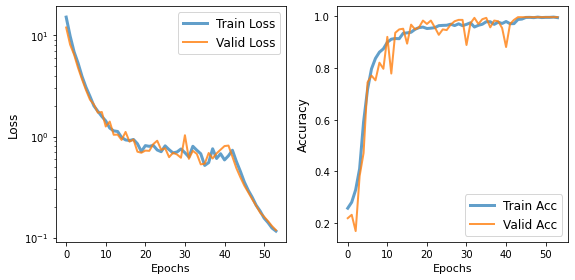

In [21]:
loss = stn_result.history['loss']
val_loss = stn_result.history['val_loss']

acc = stn_result.history['accuracy'] 
val_acc = stn_result.history['val_accuracy']

# top5_acc = stn_model.history['top5 acc']
# val_top5_acc = stn_model.history['val_top5 acc']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linewidth=3, alpha=0.7, label='Train Loss')
plt.plot(epochs, val_loss, linewidth=2, alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linewidth=3, alpha=0.7, label='Train Acc')
plt.plot(epochs, val_acc, linewidth=2, alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
# plt.subplot(1, 3, 3)
# plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Top 5 Acc')
# plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Top5 Acc') 
# plt.xlabel('Epochs', fontsize=11)
# plt.ylabel('Top5 Accuracy', fontsize=12)
# plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

Building Localization Network with input shape: (None, 48, 48, 1)
Classification Report:

              precision    recall  f1-score   support

       anger       0.98      0.99      0.99       119
    contempt       0.98      0.99      0.98       119
     disgust       0.99      1.00      1.00       118
        fear       1.00      1.00      1.00       119
   happiness       1.00      1.00      1.00       119
     neutral       0.98      0.93      0.96       119
     sadness       0.98      1.00      0.99       118
    surprise       1.00      1.00      1.00       118

    accuracy                           0.99       949
   macro avg       0.99      0.99      0.99       949
weighted avg       0.99      0.99      0.99       949



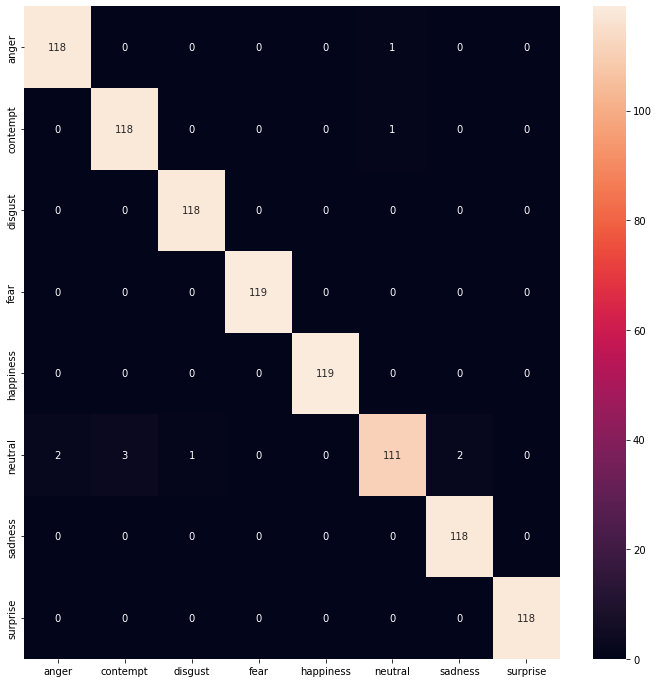

In [22]:
def conf_matrix(predictions): 

    rounded_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(rounded_labels, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr = classification_report(rounded_labels, np.argmax(np.round(predictions), axis=1), 
                                target_names=[dir_list[i] for i in range(len(dir_list))])
    print(cr)
    plt.figure(figsize=(12, 12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[dir_list[i] for i in range(len(dir_list))], 
                yticklabels=[dir_list[i] for i in range(len(dir_list))], fmt="d")
    fig = sns_hmp.get_figure()

saved_stn_model = load_model('saved_models/best_weight_CK+.h5', custom_objects={'STN': STN}, compile=False)
pred_class = saved_stn_model.predict(X_test)
conf_matrix(pred_class)

In [23]:
model_json = stn_model.to_json()
with open("saved_models/CK+_model.json", "w") as json_file:
    json_file.write(model_json)